In [188]:
# Importing libraries
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchtext import vocab
from torchtext.vocab import build_vocab_from_iterator
# from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
import matplotlib.pyplot as plt
from tqdm import tqdm
from rouge import Rouge
import re

In [189]:
class EncoderModel(nn.Module):
    def __init__(self,input_dim,embed_dim,drop=0.3):
        super(EncoderModel,self).__init__()
        self.lin = nn.Linear(input_dim,embed_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
    
    def forward(self,x):
        for name,param in self.lin.named_parameters():
            # print(name + " ** " + str(param))
            param.requires_grad=True # ensures params are trainable

        x = self.lin(x)
        return self.dropout(self.relu(x))

In [190]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_dim,hidden_size,vocab_size,num_layers):
        super(DecoderRNN,self).__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
        self.lstm = nn.LSTM(embed_dim,hidden_size,num_layers)
        self.linear = nn.Linear(hidden_size,vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,features,captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0),embeddings),dim=0) #if Caption words: (n,5); Features: (5,); Cat: (n+1,5)
        hiddens,_ = self.lstm(embeddings) # feeding all inputs at once and getting the list of hidden states
        outputs = self.linear(hiddens)
        return outputs


In [191]:
class EncoderDecoder(nn.Module):
    def __init__(self,input_dim,embed_dim,hidden_size,vocab_size,num_layers,drop=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderModel(input_dim,embed_dim,drop)
        self.decoder = DecoderRNN(embed_dim,hidden_size,vocab_size,num_layers)
    
    def forward(self,x,captions):
        features = self.encoder(x)
        outputs = self.decoder(features,captions)
        return outputs
    
    # For inference -
    def caption_image(self,image_embed,vocab,max_length=65):
        with torch.no_grad():
            x = self.encoder(image_embed).unsqueeze(0)
            states = None
            result_caption=[]

            for _ in range(65):
                hiddens,states = self.decoder.lstm(x,states)
                output = self.decoder.linear(hiddens.squeeze(0)) # Directly produces the one-hot word
                predicted = output.argmax(0)
                # print(predicted)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)

                if vocab.itos[predicted.item()]=="<EOS>":
                    break
                
        return [vocab.itos[idx] for idx in result_caption]

## Next part

In [106]:
em = nn.Embedding(25,5)
d =nn.Dropout(0.5)
y = em(torch.tensor([23]))
y,y.shape,d(y)

(tensor([[ 1.0210, -1.0482, -0.4479,  0.2209, -0.9994]],
        grad_fn=<EmbeddingBackward0>),
 torch.Size([1, 5]),
 tensor([[ 2.0420, -2.0963, -0.8959,  0.0000, -1.9989]], grad_fn=<MulBackward0>))

In [7]:
try:
    y = em(torch.tensor([25]))
except:
    print("It's out of range for the embedding's vocab size!")

It's out of range for the embedding's vocab size!


In [8]:
y = em(torch.tensor([23]))
a = torch.tensor([1,2,3,4,5]).unsqueeze(0)
a.shape,y.shape

(torch.Size([1, 5]), torch.Size([1, 5]))

In [9]:
embeddings = torch.cat((a,y),dim=0)
embeddings.shape

torch.Size([2, 5])

# Training

In [192]:
X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")
X_train.shape,y_train.shape # Max length is taken as 65, no tweet has a higher length in the train dataset

(torch.Size([46294, 1283]), torch.Size([46294, 65]))

In [193]:
train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [194]:
VOCAB_SIZE = 118768
MAX_LEN = 65
FEAT_DIM = 1283
VOCAB_PAD_INDEX = 1

In [195]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model=False
save_model=True

In [196]:
input_dim = FEAT_DIM
embed_dim = 512
hidden_size = 256
vocab_size = VOCAB_SIZE
num_layers = 1
learning_rate = 3e-4
num_epochs = 100

In [110]:
model = EncoderDecoder(input_dim,embed_dim,hidden_size,vocab_size,num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=VOCAB_PAD_INDEX)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

if(load_model):
    model.load_state_dict(torch.load("modeltweet.pth"))
    
model.train()
losses=[]
for epoch in range(num_epochs):
    for idx,(X,y) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        X = X.to(device)
        y = y.to(device).T
        print("X.shape",X.shape,"; y.shape",y.shape,"; y.reshape(-1).shape",y.reshape(-1).shape)
        outputs = model(X,y[:-1])
        print("outputs.shape",outputs.shape,"; outputs.reshape(-1,outputs.shape[2]).shape ",outputs.reshape(-1,outputs.shape[2]).shape) # 3D tensor. This is nn.Linear(hiddens)

        loss = criterion(outputs.reshape(-1,outputs.shape[2]),y.reshape(-1))
        # print(loss.item())
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
    torch.save(model.state_dict(), "modeltweet.pth")

NameError: name 'tqdm' is not defined

## Note
### Why is the first dim 65+1? Coz 65 is the length of the string, but the image is also inputted so in total we get 66 output words.
### (num of words outputted, number of captions in batch, vocab size of each word)

# In the loss

outputs is of the shape (batches*words,vocab size)
y (labels) is of the shape (batches*words,1). That last number should be converted to its one-hot encoding in order to apply cross entropy. This is automatically taken care of by the function during training.

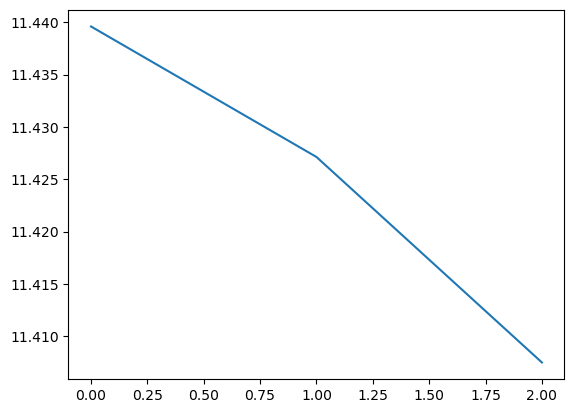

In [25]:
import matplotlib.pyplot as plt
plt.plot(losses)

# Inference

In [197]:
model = EncoderDecoder(input_dim,embed_dim,hidden_size,vocab_size,num_layers).to(device)
model.load_state_dict(torch.load("modeltweet_jarvis.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [198]:
X_test = torch.load("X_test.pt")
y_test = torch.load("y_test.pt")

In [199]:
y_test.shape, X_test.shape

(torch.Size([5144, 65]), torch.Size([5144, 1283]))

In [200]:
with open("y_train.pkl",'rb') as file1:
    y_train_pkl = pickle.load(file1)

all_words = [word for sentence in y_train_pkl for word in sentence.split()]+["<EOS>","<SOS>"]
vocab = build_vocab_from_iterator([all_words])

1lines [00:00,  8.67lines/s]


In [205]:
img = X_test[41,:]
caption = y_test[41,:]

sent = model.caption_image(img,vocab)
ref = remove_words_in_angle_brackets(" ".join([vocab.itos[idx] for idx in caption])).split()
cand = remove_words_in_angle_brackets(" ".join(sent)).split()

print(" ".join(cand))
print()
print(" ".join(ref))
print('Rouge score -> {}'.format(Rouge().get_scores(" ".join(cand)," ".join(ref))[0]['rouge-l']['r']))
# Should give a sentence output. This is like model.predict. I can then check out the 

Filing a lot of hats, and gloom on the road can be difficult.

Filing a life insurance claim can typically be done in four steps. See what else we’re doing to make life insurance a little less complicated.
Rouge score -> 0.18181818181818182


In [202]:
def remove_words_in_angle_brackets(text):
    pattern = r'<[^>]*>'
    result = re.sub(pattern, '', text)
    return result.strip()

# BLEU Score Inference

In [209]:
arr = []
arr2=[]
for i in range(500):
    # print(i)
    img = X_test[i,:]
    caption = y_test[i,:]

    sent = model.caption_image(img,vocab)
    ref = remove_words_in_angle_brackets(" ".join([vocab.itos[idx] for idx in caption])).split()
    cand = remove_words_in_angle_brackets(" ".join(sent)).split()

    # print(" ".join(cand))
    # print()
    # print(" ".join(ref))
    # print('BLEU score -> {}'.format(sentence_bleu(ref, cand)))
    # arr2.append(sentence_bleu([ref], cand, weights=(.7, .2, .1, 0), smoothing_function=SmoothingFunction().method1))
    if(cand!=[]):
        arr.append(float(Rouge().get_scores(" ".join(cand)," ".join(ref))[0]['rouge-2']['f']))
    
print(arr,i)

[0.0, 0.0, 0.0, 0.03389830009767382, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06451612428720119, 0.0, 0.7575757526492196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0999999968000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032786880548240395, 0.0, 0.0, 0.0, 0.02739725543253979, 0.0, 0.0, 0.0, 0.16666666166666683, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09999999511250024, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0434782566351611, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03846153364645031, 0.0, 0.0, 0.033898300718185, 0.036363631497521316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142856951530618, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035714281632653534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

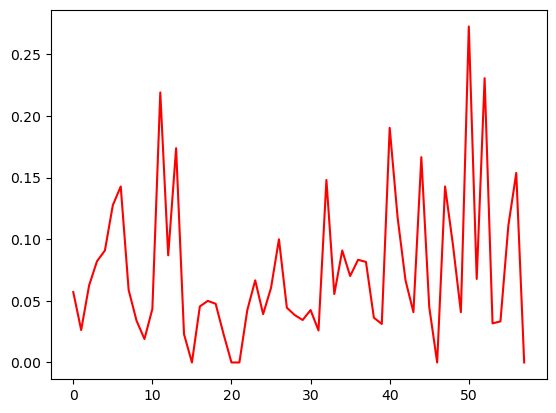

In [177]:
plt.plot(arr,'r-')

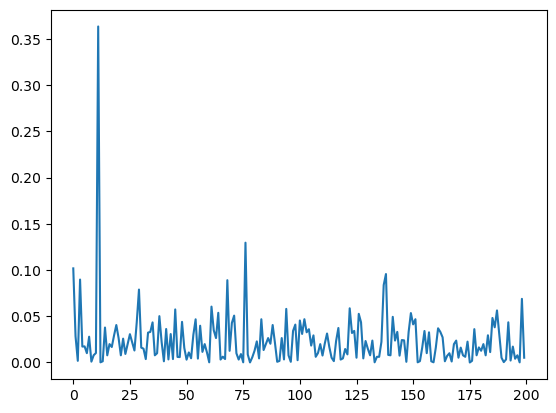

In [126]:
plt.plot(arr,'b-')

In [128]:
max(arr),np.argmax(np.array(arr))

(0.36358267759002705, 11)

In [203]:
img = X_test[40,:]
caption = y_test[40,:]

sent = model.caption_image(img,vocab)
ref = remove_words_in_angle_brackets(" ".join([vocab.itos[idx] for idx in caption])).split()
cand = remove_words_in_angle_brackets(" ".join(sent)).split()

print(" ".join(cand))
print()
print(" ".join(ref))
print(sentence_bleu([ref], cand, weights=(.9, .1, 0, 0), smoothing_function=SmoothingFunction().method1))

BREAKING: Gunmen Kidnap Father For Allegedly Stealing Shoes Worth N1.22m

Lokoja Popular Shop Owner Killed, Many Abducted
0
